# Purely data-driven nodel trained with displacement field

## Import packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## User defined neural network
* A fully-connected feed-forward network
    * **n_input** - dimension of input, 2 in this case(x and y lcation)
    * **n_output** - dimension of output, 1 in this case (u - horizontal or v - vertical displacemnt)
    * **n_layer** - number of hidden layers
    * **n_nodes** - number of nodes of each hidden layer
* **two networks are defined seperately for u and v**

In [2]:
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer
        
        self.Input = nn.Linear(n_input, n_nodes)   # linear layer
        nn.init.xavier_uniform_(self.Input.weight) # wigths and bias initiation
        nn.init.normal_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)
        
        self.Hidden = nn.ModuleList() # hidden layer list
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)
        

    def forward(self, x):
        y = torch.tanh(self.Input(x)) # tanh activation function
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y

## Function for first partial derivtives

In [3]:
def derivativs2(x, Net):
    
    w = Net(x)
    dw_x = []
    dw_y = []
    
    for i in range(w.size()[1]):
        
        #print(Net(x),func(x).view(-1,1),w)
        dw_xy = torch.autograd.grad(w[:,i], x, torch.ones_like(w[:,i]), retain_graph=True, 
                                    create_graph=True, allow_unused=True)
        dw_x.append(dw_xy[0][:,0].view(-1,1))
        dw_y.append(dw_xy[0][:,1].view(-1,1))

    return w, dw_x, dw_y

## Preparing training data

In [4]:
data = pd.read_csv('CH-R2.csv')
X_train = data.iloc[:, 5:7].to_numpy()
U = data.iloc[:,11:13].to_numpy()
LE = data.iloc[:,13:16].to_numpy()
sig = data.iloc[:,16:19].to_numpy()
U1 = U[:,0].reshape(-1, 1)
U2 = U[:,1].reshape(-1, 1)
eps11 = LE[:,0].reshape(-1, 1)
eps22 = LE[:,1].reshape(-1, 1)
eps12 = LE[:,2].reshape(-1, 1)
sig11 = sig[:,0].reshape(-1, 1)
sig22 = sig[:,1].reshape(-1, 1)
sig12 = sig[:,2].reshape(-1, 1)

In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_train = X_train/10
U = torch.tensor(U, dtype=torch.float32)
U = U / 10

In [6]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X, Y):
        
        self.X = X
        self.Y = Y
        
    def __len__(self):
        
        return len(self.X)

    def __getitem__(self, index):
        
        x = self.X[index]
        y = self.Y[index]

        return x, y

In [8]:
def err(X, Y):
    
    return torch.mean(torch.mean((X-Y)**2))

In [7]:
Net_u = Net(2, 2, 5, 5)

In [16]:
# Construct neural network
# optimizer
nepoches = 6000
learning_rate = 1e-4
optimizer = torch.optim.Adam(Net_u.parameters(), lr=learning_rate)
training_set = Dataset(X_train, U)
training_generator = torch.utils.data.DataLoader(training_set, batch_size= 128)
training_loss = []
for epoch in range(nepoches):
    
    for X_batch, Y_batch in training_generator:
        
        Y_pred = Net_u(X_batch)
    
        
        loss = err(Y_pred, Y_batch)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}: loss:{loss:.4e} ')

epoch:100: loss:1.3068e-09 
epoch:200: loss:7.9199e-10 
epoch:300: loss:6.5938e-10 
epoch:400: loss:5.6739e-10 
epoch:500: loss:5.0256e-10 
epoch:600: loss:4.5836e-10 
epoch:700: loss:4.2671e-10 
epoch:800: loss:4.0885e-10 
epoch:900: loss:3.8715e-10 
epoch:1000: loss:3.7287e-10 
epoch:1100: loss:3.6011e-10 
epoch:1200: loss:3.4196e-10 
epoch:1300: loss:3.2650e-10 
epoch:1400: loss:3.1334e-10 
epoch:1500: loss:3.0025e-10 
epoch:1600: loss:2.8606e-10 
epoch:1700: loss:2.7251e-10 
epoch:1800: loss:2.5944e-10 
epoch:1900: loss:2.4749e-10 
epoch:2000: loss:2.3811e-10 
epoch:2100: loss:2.2992e-10 
epoch:2200: loss:2.2266e-10 
epoch:2300: loss:2.1842e-10 
epoch:2400: loss:2.1529e-10 
epoch:2500: loss:2.1148e-10 
epoch:2600: loss:2.0871e-10 
epoch:2700: loss:2.0485e-10 
epoch:2800: loss:2.0222e-10 
epoch:2900: loss:1.9849e-10 
epoch:3000: loss:1.9564e-10 
epoch:3100: loss:1.9282e-10 
epoch:3200: loss:1.8833e-10 
epoch:3300: loss:1.8622e-10 
epoch:3400: loss:1.8435e-10 
epoch:3500: loss:1.8087

In [10]:
X_train.requires_grad = True
U_pred, dux, duy = derivativs2(X_train, Net_u)

u1 = U_pred[:,0].reshape(-1,1)
u2 = U_pred[:,1].reshape(-1,1)
X = X_train[:,0].detach().numpy()*10
Y = X_train[:,1].detach().numpy()*10
U_pred = Net_u(X_train).detach().numpy()*10
u1 = U_pred[:,0].reshape(-1,1)
u2 = U_pred[:,1].reshape(-1,1)

In [11]:
max(u1)

array([0.17627612], dtype=float32)

In [12]:
np.corrcoef(U2.reshape(1,-1), u2.reshape(1,-1))

array([[1.        , 0.99923286],
       [0.99923286, 1.        ]])

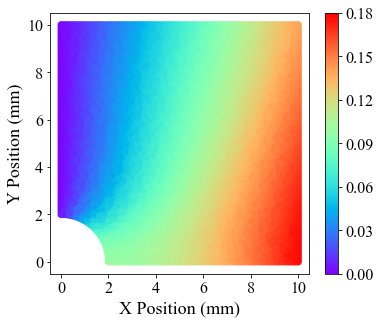

In [88]:
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c = u1, vmin=0, vmax=0.18, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf, ticks=[0,0.03,0.06,0.09,0.12,0.15,0.18])
#cb.ax.locator_params(nbins=6)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
plt.savefig('CH-R2-NN10-10.png', dpi=600, transparent=True)
plt.show()

In [13]:
du_x, du_y = dux[0], duy[0]
dv_x, dv_y = dux[1], duy[1]

E, mu = 70, 0.3
sig_x = (du_x + mu*dv_y)*E/(1 - mu**2) 
sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
sig_xy = (dv_x + du_y)*E/(1 + mu)/2.

#X = Xf[:,0].detach().numpy().reshape(-1,1)
#Y = Xf[:,1].detach().numpy().reshape(-1,1)

sig_x = sig_x.detach().numpy()
sig_y = sig_y.detach().numpy() 
sig_xy = sig_xy.detach().numpy()

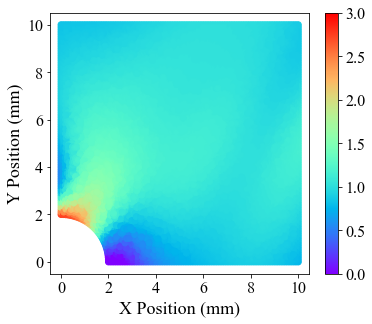

In [14]:
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c = sig_x, vmin=0, vmax=3.0, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf)
cb.ax.locator_params(nbins=7)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
#plt.savefig('CH-R2-S-NN10-10-3.png', dpi=600, transparent=True)
plt.show()

In [15]:
np.corrcoef(sig12.reshape(1,-1), sig_xy.reshape(1,-1))

array([[1.        , 0.84107699],
       [0.84107699, 1.        ]])

In [83]:
data_out = np.hstack([X.reshape(-1,1),Y.reshape(-1,1),u1,u2,sig_x,sig_y,sig_xy])
df_out = pd.DataFrame(data_out, columns=['X', 'Y', 'U', 'V', 'Sig_x', 'Sig_y', 'Sig_xy'])

In [70]:
data_out = np.hstack([X.reshape(-1,1),Y.reshape(-1,1),U1,U2,sig11,sig22,sig12])
df_out = pd.DataFrame(data_out, columns=['X', 'Y', 'U', 'V', 'Sig_x', 'Sig_y', 'Sig_xy'])

In [84]:
df_out.to_csv('CH-R2-NN10-10.csv')